## Section1 Part1 Simulated Datasets Generation and Comparation 
#### Ke Liu

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sci
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import subprocess as sp
import matplotlib.font_manager as font_manager
from os.path import join, split
font_manager.fontManager.addfont('/home/qukun/liuke/miniconda3/fonts/Arial.ttf')
mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.serif'] = ['Arial']

### Step0 Transform real eccDNA information into profile BED files

##### 0.1 Dataset1-Sperm cells

In [ ]:
def simple2bed(dataset_simple):
    dataset_simple = dataset_simple[~(dataset_simple[0]=='chrM')]
    dataset_simple.columns = ['Chromosome','Start','End','Length','Reads', 'Type']
    dataset_simple.insert(4, 'eccID', ['simple{0}'.format(i) for i in range(1,len(dataset_simple)+1)])
    return dataset_simple
def chimeric2bed(dataset_chimeric):
    dataset_chim = pd.DataFrame(columns=['Chromosome','Start','End','Length', 'eccID'])
    k=0
    for i in dataset_chimeric.index:
        for j in range(int(dataset_chimeric.shape[1]/4)):
            if not (dataset_chimeric.loc[i,4*j].startswith('chr')):
                break
            dataset_chim.loc[k] =  [dataset_chimeric.loc[i,4*j], dataset_chimeric.loc[i,4*j+1], dataset_chimeric.loc[i,4*j+2], dataset_chimeric.loc[i,4*j+3], 'chim'+str(i+1)]
            k+=1
    dataset_chim = dataset_chim[~dataset_chim.eccID.isin(dataset_chim[dataset_chim.Chromosome=='chrM'].eccID)]
    return dataset_chim

In [ ]:
dataset1_simple_raw = pd.read_excel('~/workspace/benchmark/data/sim/raw/dataset1.simple.xlsx',header=None)
dataset1_chimeric_raw = pd.read_excel('~/workspace/benchmark/data/sim/raw/dataset1.chimeric.xlsx',skiprows=3,dtype=str,names=range(86))
dataset1_simple = simple2bed(dataset1_simple_raw)[['Chromosome','Start','End','Length', 'eccID']]
dataset1_chimeric = chimeric2bed(dataset1_chimeric_raw)
dataset1_merge = pd.concat([dataset1_simple,dataset1_chimeric])
dataset1_simple.to_csv('~/workspace/benchmark/data/sim/profile/dataset1.simple.bed',sep='\t',index=None,header=None)
dataset1_chimeric.to_csv('~/workspace/benchmark/data/sim/profile/dataset1.chimeric.bed',sep='\t',index=None,header=None)
dataset1_merge.to_csv('~/workspace/benchmark/data/sim/profile/dataset1.merge.bed',sep='\t',index=None,header=None)

##### 0.2 Dataset2-EJM cells & Dataset3-JJN3 cells

In [ ]:
def split2region(region):
    temp = region.split(',')
    region_table = pd.DataFrame(columns=['Chromosome','Start','End','Length','Strand'])
    for i in range(len(temp)):
        chrom = temp[i].split(':')[0]
        ss = temp[i].split(':')[1].split('-')
        start = ss[0]
        end = ss[1].split('_')[0]
        strand = ss[1].split('_')[1]
        length = int(end)-int(start)+1
        region_table.loc[i] = [chrom,start,end,length,strand]
    return region_table

def result2bed(result,coverage=False):
    dataset4_merge = pd.DataFrame(columns=['Chromosome','Start','End','Length','eccID','Strand','Coverage'])
    for i in result.index:
        region_table = split2region(result.loc[i,'merge_region'])
        region_table.insert(region_table.shape[1],'Coverage',result.loc[i,'coverage'])
        region_table.insert(4,'eccID',result.loc[i,'id'])
        dataset4_merge = pd.concat([dataset4_merge,region_table],axis=0)
    dataset4_merge = dataset4_merge.reset_index()
    dataset4_merge = dataset4_merge.drop('index',axis=1)
    dataset4_merge.loc[dataset4_merge[dataset4_merge.Strand==''].index,'Strand']='-'
    simple_bed = dataset4_merge[dataset4_merge.eccID.isin(result[result.num_region==1].id)]
    chimeric_bed = dataset4_merge[dataset4_merge.eccID.isin(result[result.num_region>1].id)]
    return  simple_bed, chimeric_bed

In [ ]:
for dataset in ['dataset2','dataset3']:
    locals()[dataset] = pd.read_csv('/home/qukun/liuke/workspace/benchmark/data/sim/raw/'+dataset+'.txt', sep='\t')
    locals()[dataset] = locals()[dataset][locals()[dataset]['eccdna_status']=='cyclic']
    locals()[dataset+'_bed'] = result2bed(locals()[dataset])
    locals()[dataset+'_simple'] = locals()[dataset+'_bed'][0][['Chromosome','Start','End','Length','eccID']]
    locals()[dataset+'_chimeric'] = locals()[dataset+'_bed'][1][['Chromosome','Start','End','Length','eccID']]
    locals()[dataset+'_merge'] = pd.concat([locals()[dataset+'_simple'],locals()[dataset+'_chimeric']])
    locals()[dataset+'_simple'].to_csv('~/workspace/benchmark/data/sim/profile/'+dataset+'.simple.bed',sep='\t',index=None,header=None)
    locals()[dataset+'_chimeric'].to_csv('~/workspace/benchmark/data/sim/profile/'+dataset+'.chimeric.bed',sep='\t',index=None,header=None)
    locals()[dataset+'_merge'].to_csv('~/workspace/benchmark/data/sim/profile/'+dataset+'.merge.bed',sep='\t',index=None,header=None)

##### 0.3 Dataset4 - kelly cells

In [ ]:
dataset4 = pd.read_csv('/home/qukun/liuke/workspace/benchmark/data/sim/raw/dataset4.tsv',sep='\t')
dataset4_subset =dataset4[~dataset4.fragments.isna()]
dataset4_merge = pd.DataFrame(columns=['Chromosome','Start','End','Length','eccID'])
i=0
ecci=1
for j in dataset4_subset.index:
    if (dataset4_subset.loc[j,'Nfragment']==1):
        temp = dataset4_subset.loc[j,'fragments'][:-3]
        dataset4_merge.loc[i,'Chromosome'] = temp.split(':')[0]
        dataset4_merge.loc[i,'Start'] = temp.split(':')[1].split('-')[-2]
        dataset4_merge.loc[i,'End'] =  temp.split(':')[1].split('-')[-1]
        dataset4_merge.loc[i,'Length'] = int(dataset4_merge.loc[i,'End']) - int(dataset4_merge.loc[i,'Start'])
        dataset4_merge.loc[i,'eccID'] = 'ecc'+str(ecci)
        i+=1
        ecci+=1
    if (dataset4_subset.loc[j,'Nfragment']!=1):
        for k in range(dataset4_subset.loc[j,'Nfragment']):
            temp = dataset4_subset.loc[j,'fragments'].split('|')[k][:-3]
            dataset4_merge.loc[i,'Chromosome'] = temp.split(':')[0]
            dataset4_merge.loc[i,'Start'] = temp.split(':')[1].split('-')[-2]
            dataset4_merge.loc[i,'End'] =  temp.split(':')[1].split('-')[-1]
            dataset4_merge.loc[i,'Length'] = int(dataset4_merge.loc[i,'End']) - int(dataset4_merge.loc[i,'Start'])
            dataset4_merge.loc[i,'eccID'] = 'ecc'+str(ecci)
            i+=1
        ecci+=1
dataset4_merge = dataset4_merge[~dataset4_merge.eccID.isin(dataset4_merge[dataset4_merge.Chromosome=='chrM'].eccID)]
count_table = pd.DataFrame(dataset4_merge.eccID.value_counts())
subset_simple = count_table[count_table.eccID==1]
dataset4_simple = dataset4_merge[dataset4_merge.eccID.isin(list(subset_simple.index))]
subset_chimeric = count_table[count_table.eccID!=1]
dataset4_chimeric = dataset4_merge[dataset4_merge.eccID.isin(list(subset_chimeric.index))]
dataset4_merge.to_csv('~/workspace/benchmark/data/sim/profile/dataset4.merge.bed',sep='\t',index=None,header=None)
dataset4_simple.to_csv('~/workspace/benchmark/data/sim/profile/dataset4.simple.bed',sep='\t',index=None,header=None)
dataset4_chimeric.to_csv('~/workspace/benchmark/data/sim/profile/dataset4.chimeric.bed',sep='\t',index=None,header=None)

##### 0.4 Dataset5 - Melluoblastoma

In [ ]:
dataset5 = pd.read_excel('~/workspace/benchmark/data/sim/raw/dataset5.xlsx',skiprows=14)
dataset5_subset = dataset5[dataset5['T-tissue-dyn']!=0]
dataset5_subset.insert(5,'ecc_id',['ecc'+str(i+1) for i in range(dataset5_subset.shape[0])])
dataset5_merge = dataset5_subset[['ecc_chr', 'ecc_start', 'ecc_end', 'ecc_length', 'ecc_id']]
dataset5_merge.columns = ['Chromosome','Start','End','Length','eccID']
dataset5_merge.to_csv('~/workspace/benchmark/data/sim/profile/dataset5.merge.bed',sep='\t',index=None,header=None)

##### 0.5 Dataset6 - Muscle

In [ ]:
dataset6 = pd.read_csv('~/workspace/benchmark/data/sim/raw/dataset6.csv',sep='\t',names=['Chromosome','Start','End','Splits','Discordants','Length','eccID'])
dataset6.eccID = ['ecc'+str(i+1) for i in range(len(dataset6))]
dataset6_merge = dataset6[~(dataset6.Chromosome=='chrM')][['Chromosome','Start','End','Length','eccID']]
dataset6_merge.to_csv('~/workspace/benchmark/data/sim/profile/dataset6.merge.bed',sep='\t',index=None,header=None)

##### 0.6 Dataset7 - OVCAR8

In [ ]:
dataset7 = pd.read_table('~/workspace/benchmark/data/sim/raw/dataset7.txt.gz',compression='gzip',sep='\t',skiprows=1,header=None)
dataset7.columns = ['Chromosome','Start','End','Coverage']
dataset7.insert(3,'Length',dataset7.End-dataset7.Start)
dataset7.insert(4,'eccID',['ecc'+str(i+1) for i in range(dataset7.shape[0])])
dataset7_merge = dataset7[['Chromosome', 'Start', 'End', 'Length', 'eccID']]
dataset7_merge.to_csv('~/workspace/benchmark/data/sim/profile/dataset7.merge.bed',sep='\t',index=None,header=None)

### Step1 Generate simulated datasets with mean sequencing depth 50 with ecsim

##### 1.1 PBS script to generate simulated eccDNA datasets with ecsim 

`For datasets 1-3 and 5, the random seed is set as 2023, for datasets4 and datasets 6-8 the random seed is set as 2024`

### Step2 Generate downsampled simulated datasets with mean sequencing depth 45 - 5 with ecsim

##### 2.1 Downsample the coverage of each eccDNA in each datasets

In [ ]:
for i in list(range(1,8)):
    temp_50 = pd.read_table('/home/qukun/liuke/workspace/benchmark/data/sim/dataset'+str(i)+'/dataset'+str(i)+'.50/dataset'+str(i)+'.50.lib.csv')
    for j in range(1,10):
        locals()['temp_'+str(5*j)]=temp_50.copy()
        locals()['temp_'+str(5*j)].realcov=locals()['temp_'+str(5*j)].realcov*0.1*j
        locals()['temp_'+str(5*j)].tempcov=locals()['temp_'+str(5*j)].tempcov*0.1*j
        temp_path = '/home/qukun/liuke/workspace/benchmark/data/sim/dataset'+str(i)+'/dataset'+str(i)+'.'+str(5*j)
        if not os.path.exists(temp_path):
            os.makedirs(temp_path)
        locals()['temp_'+str(5*j)].to_csv(temp_path+'/dataset'+str(i)+'.'+str(5*j)+'.lib.csv',sep='\t',index=None)

##### 2.2 PBS script to generate downsampled simulated eccDNA datasets with ecsim 

### Step3 Generate simulated datasets of different chimeric eccDNA proportion at mean sequencing depth 20 with ecsim

##### 3.1 PBS script to generate simulated eccDNA datasets of different chimeric DNA proportion at mean sequencing depth 20 with ecsim 

`For datasets 1-3, the random seed is set as 2023, for datasets4 the random seed is set as 2024`

### Step4 Visualize the similarity of simulated and real datasets

##### 4.0 Information of real datasets

In [2]:
dataset_list = ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5', 'dataset6', 'dataset7']
sample_list = ['Sperm cells (Henriksen R A, et al.)', 
               'EJM cellline (Wanchai V, et al.)', 
               'JJN3 cellline (Wanchai V, et al.)', 
               'Kelly cellline (Tüns A I, et al.)', 
               'Medulloblastoma cell (Zhu Y, et al.)', 
               'Muscle cell (Møller H D, et al.)',  
               'OVAR8 celline (Dillon L W, et al.)']
simulate_list = ['Simulated Dataset1', 'Simulated Dataset2', 'Simulated Dataset3', 'Simulated Dataset4', 'Simulated Dataset5', 'Simulated Dataset6', 'Simulated Dataset7']

In [3]:
for data in dataset_list:
    locals()[data+'_merge'] = pd.read_csv('/home/qukun/liuke/workspace/benchmark/data/sim/profile/'+data+'.merge.bed',
                                               sep='\t',
                                               names=['Chromosome','Start','End','Length','eccID']
                                              )
    locals()[data+'_simpos_ecc'] = pd.read_csv('/home/qukun/liuke/workspace/benchmark/data/sim/'+data+'/'+data+'.50/'+data+'.50.pos.bed',
                                               sep='\t',
                                               names=['ecc_chrom','ecc_start','ecc_end','ecc_length','ecc_id']
                                              )

##### 4.1 Histplot of dataset number

In [4]:
num_df = pd.DataFrame(columns=['dataset','simple_n','chimeric_n'])
for i in range(1,8):
    simple_n = locals()['dataset'+str(i)+'_merge'].eccID.value_counts()[locals()['dataset'+str(i)+'_merge'].eccID.value_counts()==1].count()
    chimeric_n = locals()['dataset'+str(i)+'_merge'].eccID.value_counts()[locals()['dataset'+str(i)+'_merge'].eccID.value_counts()!=1].count()
    num_df.loc[i,:] = ['dataset'+str(i),simple_n,chimeric_n]

In [5]:
num_df.simple_n = np.log(num_df.simple_n.astype(float))
num_df.chimeric_n = np.log(num_df.chimeric_n.astype(float))
values_simple = num_df.simple_n
colors_simple = plt.cm.Blues((values_simple-values_simple.min())/(values_simple.max()-values_simple.min()))
values_chimeric = num_df.chimeric_n[:4]
colors_chimeric = plt.cm.Greens((values_chimeric-values_chimeric.min())/(values_chimeric.max()-values_chimeric.min()))

/home/qukun/liuke/miniconda3/envs/eccDNA/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


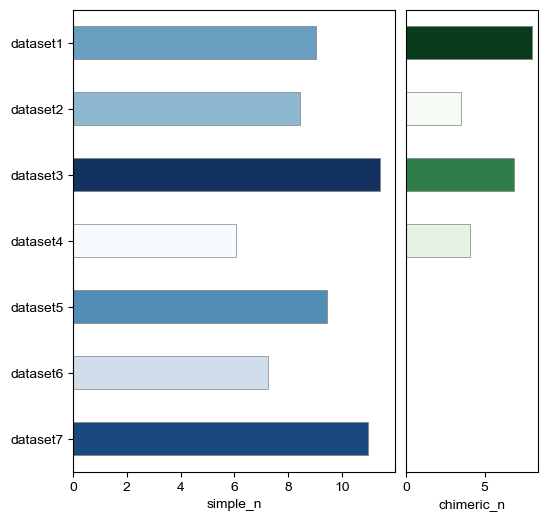

In [6]:
fig = plt.figure(figsize=(6,6))
fig = gs.GridSpec(20, 20, hspace=2, wspace=0.8)#
ax1 = plt.subplot(fig[0:20,0:14])
ax2 = plt.subplot(fig[0:20,14:20])
sns.barplot(num_df,y='dataset',x='simple_n',orient='h',palette=colors_simple,width=.5,linewidth=.5, edgecolor='.5',ax=ax1)
sns.barplot(num_df,y='dataset',x='chimeric_n',orient='h',palette=colors_chimeric,width=.5,linewidth=.5, edgecolor='.5',ax=ax2)
ax1.set_ylabel('');ax2.set_ylabel('');ax2.set_yticks([])
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/figure1b_dataset_number.pdf', dpi=300, bbox_inches='tight')

##### 4.1 Length distribution of real and simulated datasets

In [7]:
for data in dataset_list:
    locals()[data+'_real_length'] =locals()[data+'_merge'].groupby(by='eccID')['Length'].sum()
    locals()[data+'_simpos_length'] = locals()[data+'_simpos_ecc'].groupby(by='ecc_id')['ecc_length'].sum()

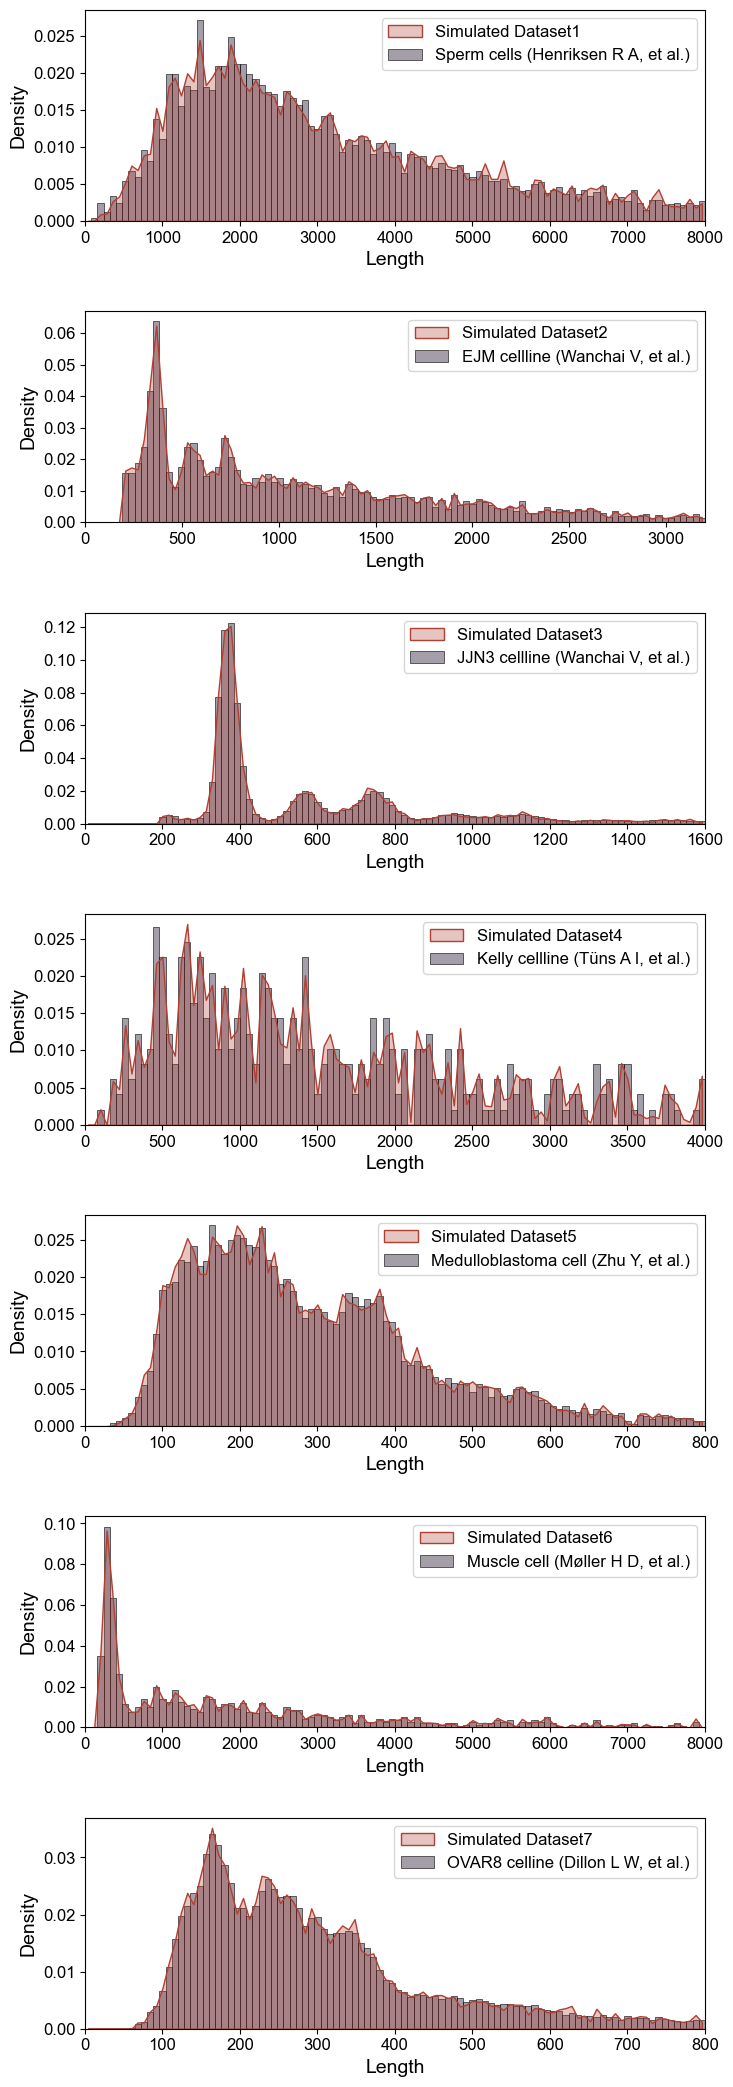

In [8]:
xlim_list=[8000,3200,1600,4000,800,8000,800]
fig = plt.figure(figsize=(8,27))
fig = gs.GridSpec(70, 20, hspace=500, wspace=0)
for i in range(7):
    locals()['ax'+str(i)] = plt.subplot(fig[10*i:10*i+8,0:20])
    sns.histplot(x=locals()[dataset_list[i]+'_real_length'],
                 binrange=(0,xlim_list[i]),
                 bins=100,
                 weights=[1/len(locals()[dataset_list[i]+'_real_length'])]*len(locals()[dataset_list[i]+'_real_length']),
                 color='#4a3e53',
                 fill=True,
                 label=dataset_list[i],ax=locals()['ax'+str(i)], alpha=.5)
    sns.histplot(x=locals()[dataset_list[i]+'_simpos_length'],
                 binrange=(0,xlim_list[i]),
                 bins=100,
                 element='poly',
                 weights=[1/len(locals()[dataset_list[i]+'_simpos_length'])]*len(locals()[dataset_list[i]+'_simpos_length']),
                 color='#AF4034',
                 fill=True,
                 label=dataset_list[i],ax=locals()['ax'+str(i)], alpha=.3)
    locals()['ax'+str(i)].set_xlim(0,xlim_list[i])
    locals()['ax'+str(i)].set_ylabel('Density',fontsize=14)
    locals()['ax'+str(i)].set_xlabel('Length',fontsize=14)
    plt.xticks(fontsize=12);plt.yticks(fontsize=12)
    locals()['ax'+str(i)].legend([simulate_list[i],sample_list[i]],
                                 loc=1,bbox_to_anchor=(1,1),fontsize=12)
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/sfigure1a_length_distribution.pdf', dpi=300, bbox_inches='tight')

##### 4.2 Comparison of eccDNA Ratios on Specific Chromosomes: Real vs. Simulated Datasets

In [9]:
chr_list = ['chr{0}'.format(a) for a in list(range(1,23))+['X','Y']]
plot_chr_df = pd.DataFrame(index=[chr_list])
for i in chr_list:
    for j in range(7):
        if i in locals()[dataset_list[j]+'_merge']['Chromosome'].value_counts().index:
            temp_chr = locals()[dataset_list[j]+'_merge']['Chromosome'].value_counts()
            plot_chr_df.loc[i,dataset_list[j]+'_merge'] = temp_chr[i]/temp_chr.sum()
        if i in locals()[dataset_list[j]+'_simpos_ecc']['ecc_chrom'].value_counts().index:
            temp_chr = locals()[dataset_list[j]+'_simpos_ecc']['ecc_chrom'].value_counts()
            plot_chr_df.loc[i,dataset_list[j]+'_simpos'] = temp_chr[i]/temp_chr.sum()
plot_chr_df=plot_chr_df.fillna(0)

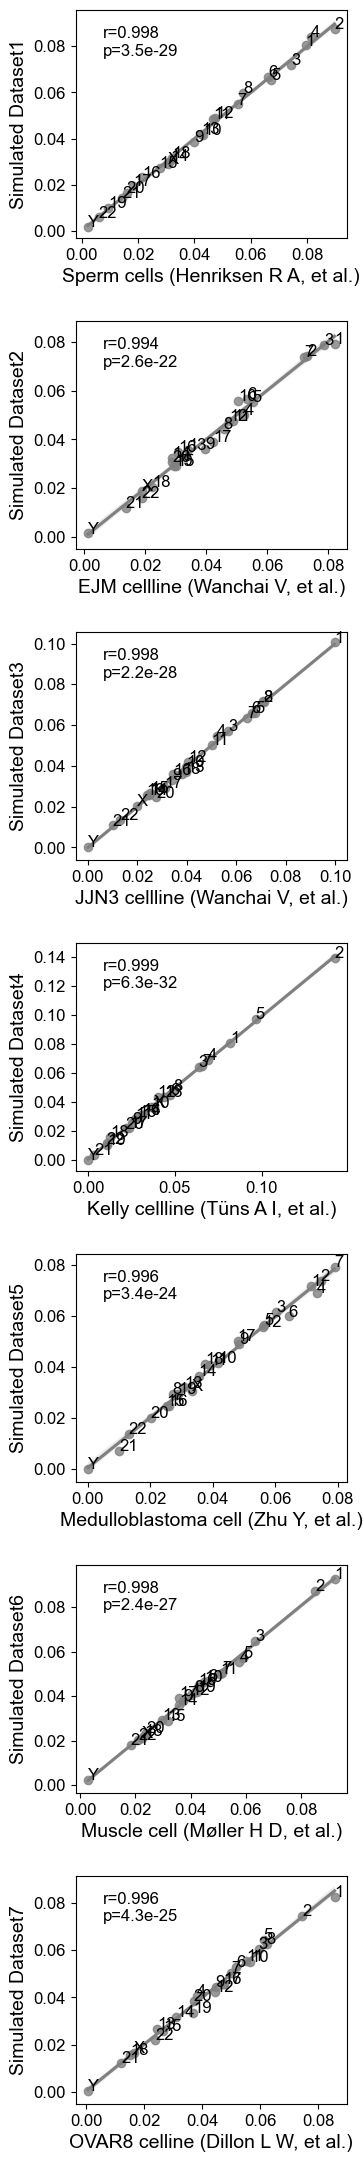

In [10]:
from sklearn.metrics import r2_score
fig = plt.figure(figsize=(3.5,28))
fig = gs.GridSpec(35, 4, hspace=0.5, wspace=0)
for i in range(7):
    locals()['ax'+str(i)] = plt.subplot(fig[5*i:5*i+4,0:4])
    sns.regplot(plot_chr_df,x=dataset_list[i]+'_merge',y=dataset_list[i]+'_simpos',color='gray')
    slope, intercept, r, p, std_err  = sci.stats.linregress(plot_chr_df[dataset_list[i]+'_merge'], plot_chr_df[dataset_list[i]+'_simpos'])
    locals()['ax'+str(i)].text(.1, .8, 'r={:.3f}\np={:.2g}'.format(r, p),transform=locals()['ax'+str(i)].transAxes, fontsize=12, color='black', weight='semibold')
    for j in chr_list:
        locals()['ax'+str(i)].text(plot_chr_df.loc[j,dataset_list[i]+'_merge'], 
                                   plot_chr_df.loc[j,dataset_list[i]+'_simpos'], 
                                   j[3:], 
                                   horizontalalignment='left', 
                                   fontsize=12, 
                                   color='black', 
                                   weight='semibold')
    locals()['ax'+str(i)].set_xlabel(sample_list[i],fontsize=14)
    locals()['ax'+str(i)].set_ylabel(simulate_list[i],fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/sfigure1b_chr_distribution.pdf', dpi=300, bbox_inches='tight')

##### 4.3 Comparison of ratio of eccDNA containing different fragments number: Real vs. Simulated Datasets

In [11]:
chr_list = ['chr{0}'.format(a) for a in list(range(1,23))+['X','Y']]
fragn_plot_df = pd.DataFrame(index=list(range(1,10))+['others'])
for data in dataset_list:
    ## Statistic of eccDNA Length and Fragments Number
    locals()[data+'_merge_fragn']= {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,'others':0}
    for i in locals()[data+'_merge'].eccID.value_counts().value_counts().index:
        ## skip eccDNA with more than 9 fragments
        if (i>9):
            locals()[data+'_merge_fragn']['others']+=locals()[data+'_merge'].eccID.value_counts().value_counts()[i]
            fragn_plot_df.loc['others',data+'_merge']+=locals()[data+'_merge'].eccID.value_counts().value_counts()[i]
            
        else: 
            locals()[data+'_merge_fragn'][i]=locals()[data+'_merge'].eccID.value_counts().value_counts()[i]
            fragn_plot_df.loc[i,data+'_merge']=locals()[data+'_merge'].eccID.value_counts().value_counts()[i]     
    locals()[data+'_simpos_fragn']= {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,'others':0}        
    for i in locals()[data+'_simpos_ecc'].ecc_id.value_counts().value_counts().index:
        if (i>9):
            locals()[data+'_simpos_fragn']['others']+=locals()[data+'_simpos_ecc'].ecc_id.value_counts().value_counts()[i]
            fragn_plot_df.loc['others',data+'_simpos_ecc']+=locals()[data+'_simpos_ecc'].ecc_id.value_counts().value_counts()[i]
        else: 
            locals()[data+'_simpos_fragn'][i]=locals()[data+'_simpos_ecc'].ecc_id.value_counts().value_counts()[i]
            fragn_plot_df.loc[i,data+'_simpos_ecc']=locals()[data+'_simpos_ecc'].ecc_id.value_counts().value_counts()[i]

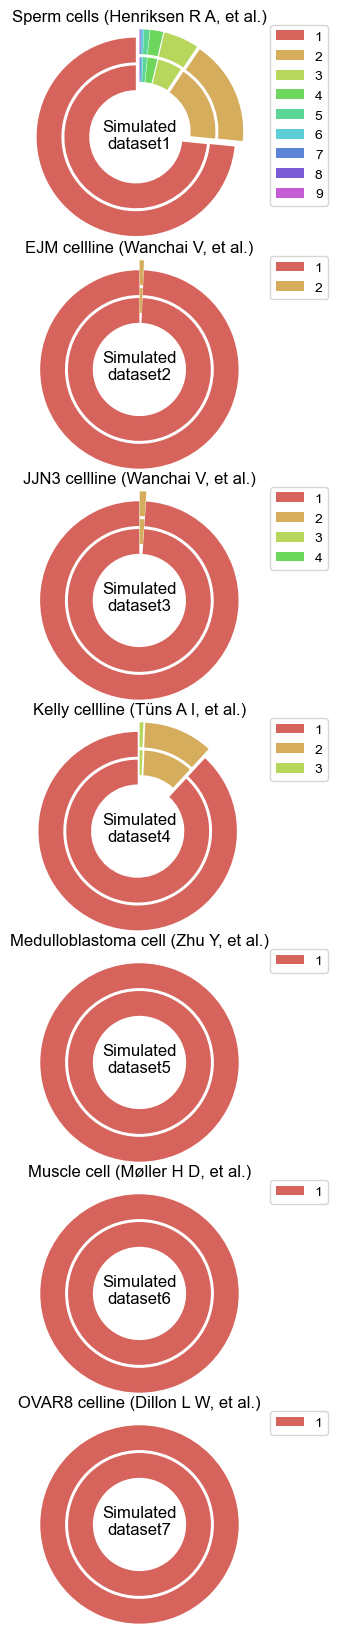

In [12]:
fig = plt.figure(figsize=(8,21))
fig = gs.GridSpec(28, 10, hspace=0, wspace=0)
for i in range(7):
    locals()['ax1'+str(i)] = plt.subplot(fig[4*i:4*i+4,0:4])
    locals()['ax2'+str(i)] = locals()['ax1'+str(i)].twinx()
    temp = fragn_plot_df[dataset_list[i]+'_merge']
    locals()[dataset_list[i]+'_merge_fragn'] = dict(zip(temp[~temp.isna()].index,temp[~temp.isna()]))
    locals()['ax1'+str(i)].pie(locals()[dataset_list[i]+'_merge_fragn'].values(),
                               labels=locals()[dataset_list[i]+'_merge_fragn'].keys(),
                               colors = sns.hls_palette(10,s=.6),
                               startangle=90,
                               radius=1,
                               labeldistance=None,
                               explode=[0.05]*len(locals()[dataset_list[i]+'_merge_fragn'].values()),
                               wedgeprops={'width':0.25,'edgecolor':'w','linewidth': 0})
    locals()['ax1'+str(i)].set_title(sample_list[i],y=0.95,fontsize=12)
    locals()['ax2'+str(i)].pie(locals()[dataset_list[i]+'_simpos_fragn'].values(),
                               labels=locals()[dataset_list[i]+'_simpos_fragn'].keys(),
                               colors = sns.hls_palette(10,s=.6),
                               startangle=90,
                               radius=0.72,
                               labeldistance=None,
                               explode=[0.05]*len(locals()[dataset_list[i]+'_simpos_fragn'].values()),
                               wedgeprops={'width':0.25,'edgecolor':'w','linewidth': 0})
    locals()['ax2'+str(i)].set_title('Simulated\n' + dataset_list[i],y=0.4,fontsize=12)
    locals()['ax1'+str(i)].legend(title="",loc=2,bbox_to_anchor=(1,1),fontsize=10)
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/sfigure1c_fragn_distribution.pdf', dpi=300, bbox_inches='tight')

##### 4.5 Compare ratio of eccDNA containing LTR elements and LTR Per eccDNA: Real vs. Simulated Datasets

In [13]:
## 用于注释 bed genebody 和 Repeats文件
def annotate(ecc_bed, LTR_bed, output):
    _shell = '~/miniconda3/envs/eccDNA/bin/bedtools intersect -wa -wb -F 1 -a {0} -b {1} > {2}'.format(ecc_bed, LTR_bed, output)
    sp.check_call(_shell, shell=True)
    return

In [14]:
for data in dataset_list:
    annotate('/home/qukun/liuke/workspace/benchmark/data/sim/profile/'+data+'.merge.bed',
             '/home/qukun/liuke/reference/ucsc/hg38/repeatmask/LTR.bed',
             '/home/qukun/liuke/workspace/benchmark/result/annotation/sim/'+data+'.real.LTR'
            )
    annotate('/home/qukun/liuke/workspace/benchmark/data/sim/'+data+'/'+data+'.50/'+data+'.50.pos.bed',
             '/home/qukun/liuke/reference/ucsc/hg38/repeatmask/LTR.bed',
             '/home/qukun/liuke/workspace/benchmark/result/annotation/sim/'+data+'.simpos.LTR'
            )

In [15]:
plot_df = pd.DataFrame(index=dataset_list,columns=['real_ratio','simpos_ratio','real_num','simpos_num'])
columns_dict = {'ecc':['ecc_chrom','ecc_start','ecc_end','ecc_length','ecc_id'],
                'LTR':['ecc_chrom','ecc_start','ecc_end','ecc_length','ecc_id','LTR_chrom','LTR_start','LTR_end','LTR_type','LTR','LTR_strand','LTR_id']}

for data in dataset_list:
    path_dict ={'real':{'ecc':'/home/qukun/liuke/workspace/benchmark/data/sim/profile/'+data+'.merge.bed',
                        'LTR':'/home/qukun/liuke/workspace/benchmark/result/annotation/sim/'+data+'.real.LTR'},
                'simpos':{'ecc':'/home/qukun/liuke/workspace/benchmark/data/sim/'+data+'/'+data+'.50/'+data+'.50.pos.bed',
                          'LTR':'/home/qukun/liuke/workspace/benchmark/result/annotation/sim/'+data+'.simpos.LTR'}
               }
    for data_type in ['real','simpos']:
        for element_type in ['ecc','LTR']:
            locals()[data+'_'+data_type + '_' + element_type] = pd.read_csv(path_dict[data_type][element_type],
                                             sep='\t',
                                             names=columns_dict[element_type]
                                            )
        plot_df.loc[data,data_type+'_ratio'] = len(locals()[data+'_'+data_type+'_LTR'].ecc_id.unique())/len(locals()[data+'_'+data_type+'_ecc'].ecc_id.unique())
        plot_df.loc[data,data_type+'_num'] = np.log10(len(locals()[data+'_'+data_type+'_LTR'])/len(locals()[data+'_'+data_type+'_ecc'].ecc_id.unique()))

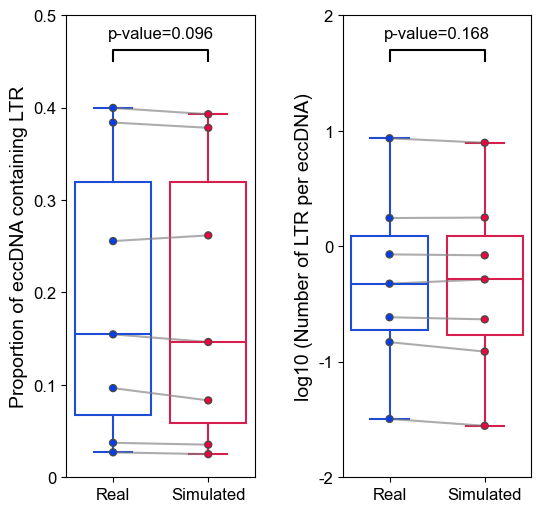

In [16]:
palette = ['#003DF5','#F5003D']
fig_list = ['ratio','num']
xticks = ['Real','Simulated']
yticks_list = [[0,0.1,0.2,0.3,0.4,0.5],[-2,-1,0,1,2]]
ylabel_list =['Proportion of eccDNA containing LTR','log10 (Number of LTR per eccDNA)']

fig = plt.figure(figsize=(6,6));
fig = gs.GridSpec(10, 11, hspace=0.1, wspace=10);
for i in range(2):
    locals()['ax'+str(i)] = plt.subplot(fig[0:10,6*i:6*i+5])
    
    ## Plot
    snsFig = sns.boxplot(data=plot_df.loc[:,plot_df.columns.str.endswith(fig_list[i])],ax=locals()['ax'+str(i)],
                         palette=palette,whis=1.5,fliersize=0)
    sns.stripplot(data=plot_df.loc[:,plot_df.columns.str.endswith(fig_list[i])],ax=locals()['ax'+str(i)],
                  palette=palette,linewidth=1,jitter=False)
    
    ## paired line
    for data in ['dataset'+str(i) for i in range(1,8)]:
        sns.lineplot(data=plot_df.loc[data,plot_df.columns.str.endswith(fig_list[i])],
                     color='gray',
                     ax=locals()['ax'+str(i)],
                     alpha=0.65,
                    )
        
    ## Annotating the t-test-dependent statistics p-value
    p=sci.stats.ttest_rel(plot_df['real_'+fig_list[i]],plot_df['simpos_'+fig_list[i]])[1]
    plt.annotate('p-value='+str(round(p,3)), (0.5, 0.05*np.min(yticks_list[i])+0.95*np.max(yticks_list[i])), ha='center', fontsize =12)
    plt.plot([0,0,1,1],[0.1*np.min(yticks_list[i])+0.9*np.max(yticks_list[i]),
                        0.075*np.min(yticks_list[i])+0.925*np.max(yticks_list[i]),
                        0.075*np.min(yticks_list[i])+0.925*np.max(yticks_list[i]),
                        0.1*np.min(yticks_list[i])+0.9*np.max(yticks_list[i])],color='black')
    
    ## Figure Parameters Set
    plt.xticks([0,1],xticks,fontsize=12)
    plt.yticks(yticks_list[i],yticks_list[i],fontsize=12)
    plt.ylabel(ylabel_list[i],fontsize=14)
    
    ## Boxplot without fill
    for j,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor((0, 0, 0, 0))
        for k in range(5*j,5*j+6):
             snsFig.lines[k].set_color(color)
                
    plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/R3C2_Simulated_Real_LTR.pdf', bbox_inches = 'tight')
    plot_df.to_csv('/home/qukun/liuke/workspace/benchmark/Figure/R3C2_Simulated_Real_LTR.csv',sep='\t')